In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, recall_score
import lightgbm

# Импорт и предобработка данных

In [59]:
df_train = pd.read_csv('train_dataset_train.csv', index_col=0)
df_test = pd.read_csv('test_dataset_test.csv', index_col=0)

In [60]:
outliers = df_train[df_train.time_to_under >= df_train.time_to_under.quantile(0.99)].index
df_train = df_train.drop(outliers)
df_train.shape

(1080110, 11)

In [61]:
df_train, df_holdout = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train.label)

In [62]:
df_sub = pd.read_csv('subway.csv', index_col=0)
df_sub = df_sub[df_sub.optimal_route_delta == 0]
df_sub = df_sub.groupby('route_id').agg({'route_dur': min}).reset_index()
df_sub['station_id'] = df_sub.route_id.apply(lambda x: x.split('_')[0]).astype(int)
df_sub['label'] = df_sub.route_id.apply(lambda x: x.split('_')[1]).astype(int)
df_sub.drop('route_id', axis=1, inplace=True)

In [63]:
df_train = df_train.merge(df_sub, how='left', left_on=['station_id', 'label'], right_on=['station_id', 'label'])
df_train['workday_len'] = df_train.time_to_under - df_train.route_dur
df_train['workday_len'] = df_train.workday_len.where(df_train.workday_len>0, 0)
df_train['route_dur'] = df_train.time_to_under - df_train.workday_len

In [64]:
# СТАТИСТИКИ ВРЕМЕНИ ПО ТИПУ БИЛЕТОВ
time_by_ticket_type_stats = df_train.groupby('ticket_type_nm')\
                               .agg({'time_to_under': [('time_min', min), ('time_max', max), ('time_mean', np.mean), ('time_median', np.median), ('time_std', np.std)],
                                     'workday_len': [('workday_min', min), ('workday_max', max), ('workday_mean', np.mean), ('workday_median', np.median), ('workday_std', np.std)],
                                     'route_dur': [('route_min', min), ('route_max', max), ('route_mean', np.mean), ('route_median', np.median), ('route_std', np.std)]})\
                               .droplevel(0, axis=1)

In [65]:
def process_date(df):
    df.pass_dttm = pd.to_datetime(df.pass_dttm)
    df['time_of_day'] = pd.cut(df.pass_dttm.dt.hour, [i for i in range(0, 25)], labels=range(24), right=False)
    df['is_dayoff'] = df.pass_dttm.dt.weekday.isin([5,6]).astype(int)
    df['weekday'] = df.pass_dttm.dt.weekday
    df['time_to_close'] = (25 * 60) - ((df.pass_dttm.dt.hour * 60) + df.pass_dttm.dt.minute)
    df['time_from_open'] = ((df.pass_dttm.dt.hour * 60) + df.pass_dttm.dt.minute) - (5.5 * 60)   

In [66]:
def process_ticket_types(df, ticket_category):
    student = df[df.ticket_type_nm.str.contains('студен') | df.ticket_type_nm.str.contains('учащ') | 
                       df.ticket_type_nm.str.contains('ордин') | df.ticket_type_nm.str.contains('аспир')].ticket_type_nm.unique()
    df['is_student'] = (df.ticket_type_nm.isin(student)).astype(int)
    suburb = df[df.ticket_type_nm.str.contains('Пригор') | df.ticket_type_nm.str.contains('област')].ticket_type_nm.unique()
    df['is_suburb'] = (df.ticket_type_nm.isin(suburb)).astype(int)
    df['ticket_type_cat'] = df.ticket_type_nm.map(ticket_category)

In [67]:
df_train = df_train.merge(time_by_ticket_type_stats, how='left', left_on='ticket_type_nm', right_index=True)
df_holdout = df_holdout.merge(time_by_ticket_type_stats, how='left', left_on='ticket_type_nm', right_index=True)
df_test = df_test.merge(time_by_ticket_type_stats, how='left', left_on='ticket_type_nm', right_index=True)

df_train = df_train.merge(df_sub[df_sub.label == 1009][['route_dur', 'station_id']], how='left', left_on='station_id', right_on='station_id', suffixes=(None, '_to_center'))
df_holdout = df_holdout.merge(df_sub[df_sub.label == 1009][['route_dur', 'station_id']], how='left', left_on='station_id', right_on='station_id', suffixes=(None, '_to_center'))
df_test = df_test.merge(df_sub[df_sub.label == 1009][['route_dur', 'station_id']], how='left', left_on='station_id', right_on='station_id', suffixes=(None, '_to_center'))

In [68]:
ticket_category = {k:v for v, k in enumerate(df_train.ticket_type_nm.unique())}

for df in [df_train, df_test, df_holdout]:
    process_date(df)
    process_ticket_types(df, ticket_category)

# Train/test split

In [69]:
X = df_train.drop(['ticket_id', 'entrance_nm', 'station_nm', 'line_nm', 'pass_dttm', 'time_to_under', 'label', 'ticket_type_nm', 'workday_len', 'route_dur'], axis=1)
y = df_train[['time_to_under', 'label']]
X_test = df_holdout.drop(['ticket_id', 'entrance_nm', 'station_nm', 'line_nm', 'pass_dttm', 'ticket_type_nm','time_to_under', 'label'], axis=1)
y_test = df_holdout[['time_to_under', 'label']]
df_test_final = df_test.drop(['ticket_id', 'entrance_nm', 'station_nm', 'line_nm', 'pass_dttm', 'ticket_type_nm'], axis=1)

In [70]:
cat_features = ['entrance_id', 'station_id', 'line_id', 'time_of_day', 'is_dayoff', 'weekday', 'is_student', 'is_suburb', 'ticket_type_cat']
X[cat_features] = X[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')
df_test_final[cat_features] = df_test_final[cat_features].astype('category')

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972099 entries, 0 to 972098
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   entrance_id          972099 non-null  category
 1   station_id           972099 non-null  category
 2   line_id              972099 non-null  category
 3   time_of_day          972099 non-null  category
 4   is_dayoff            972099 non-null  category
 5   weekday              972099 non-null  category
 6   time_to_close        972099 non-null  int64   
 7   time_from_open       972099 non-null  float64 
 8   is_student           972099 non-null  category
 9   is_suburb            972099 non-null  category
 10  ticket_type_cat      972099 non-null  category
 11  time_min             972099 non-null  float64 
 12  time_max             972099 non-null  float64 
 13  time_mean            972099 non-null  float64 
 14  time_median          972099 non-null  float64 
 15  

In [71]:
print(X_train.shape, X_valid.shape, X_test.shape)

(785535, 27) (196383, 27) (108011, 27)


# Regression

## CV

In [55]:
params = {'n_estimators': 10000,
 'learning_rate': 0.05000200424684201,
 'num_leaves': 2900,
 'max_depth': 8,
 'lambda_l1': 88,
 'lambda_l2': 12,
 'bagging_fraction': 0.9000000000000001,
 'bagging_freq': 25,
 'feature_fraction': 0.75,
 'verbosity': -1}


In [77]:
from sklearn.model_selection import KFold
CV_res = []
models = []
kf = KFold(random_state=42, shuffle=True)

for i, (trn_idx, tst_idx) in enumerate(kf.split(X)):
    X_train, X_valid, y_train, y_valid = X.iloc[trn_idx], X.iloc[tst_idx], y.time_to_under.iloc[trn_idx], y.time_to_under.iloc[tst_idx]

    lgtrain, lgval = lightgbm.Dataset(X_train, y_train), lightgbm.Dataset(X_valid, y_valid)
    lgbmodel = lightgbm.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], callbacks=[lightgbm.log_evaluation(200), lightgbm.early_stopping(50)])

    r2 = r2_score(y_test.time_to_under, lgbmodel.predict(X_test))
    CV_res.append(r2)
    print(f'Fold {i} r2_score:', r2)
    models.append(lgbmodel)

Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22590.9	valid_1's l2: 23982.2
[400]	training's l2: 22166.7	valid_1's l2: 23937.3
Early stopping, best iteration is:
[521]	training's l2: 21952	valid_1's l2: 23927.8
Fold 0 r2_score: 0.5420489188345088
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22613.4	valid_1's l2: 23998.9
[400]	training's l2: 22201.3	valid_1's l2: 23957.2
Early stopping, best iteration is:
[403]	training's l2: 22193.9	valid_1's l2: 23956.3
Fold 1 r2_score: 0.5419438237867351
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22653.1	valid_1's l2: 23764
[400]	training's l2: 22256.3	valid_1's l2: 23722.3
Early stopping, best iteration is:
[511]	training's l2: 22069.4	valid_1's l2: 23712
Fold 2 r2_score: 0.5420843848710557
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22592.9	valid_1's l2: 24072.3
[400]	training's l2: 22180.5	valid_1's 

In [78]:
lgbmodel = models[np.argmax(CV_res)]
pred_time = lgbmodel.predict(X_test)
r2_score(y_test.time_to_under, pred_time)

0.542567013132103

<AxesSubplot: >

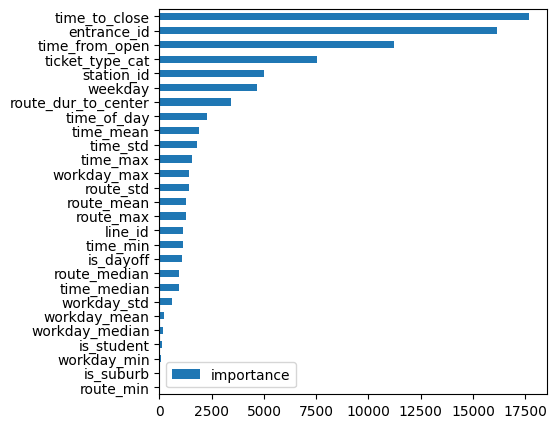

In [83]:
lgbm_feat = pd.DataFrame({'importance': lgbmodel.feature_importance()}, index=X.columns)
lgbm_feat.nlargest(30, columns='importance').sort_values(by='importance').plot(kind='barh', figsize=(5, 5))

## Model

In [42]:
trn_idx, tst_idx = splits[6]
X_train, X_valid, y_train, y_valid = X_train_all.iloc[trn_idx], X_train_all.iloc[tst_idx], y_train_all.time_to_under.iloc[trn_idx], y_train_all.time_to_under.iloc[tst_idx]

In [115]:
lgtrain, lgval = lightgbm.Dataset(X_train, y_train.time_to_under), lightgbm.Dataset(X_valid, y_valid.time_to_under)
lgbmodel = lightgbm.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], callbacks=[lightgbm.log_evaluation(200), lightgbm.early_stopping(50)])
pred_time = lgbmodel.predict(X_test)
r2_score(y_test.time_to_under, pred_time)

0.37893538718229314

# Classifier

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y.label)

In [40]:
params = {'objective': 'multiclassova',
          'n_estimators': 10000,
          'learning_rate': 0.1,
          'num_leaves': 2000,
          'max_depth': 3,
          'bagging_fraction': 0.7,
          'bagging_freq': 1,
          'verbosity': -1}

lgtrain, lgval = lightgbm.Dataset(X_train, y_train.label), lightgbm.Dataset(X_valid, y_valid.label)

model = lightgbm.LGBMClassifier(num_class= 276, **params)
model.fit(
    X_train,
    y_train.label,
    eval_set=[(X_valid, y_valid.label)],
    eval_metric="multiclass",
    callbacks=[lightgbm.early_stopping(15), lightgbm.log_evaluation(50)])  

print(recall_score(y_test.label, model.predict(X_test), average='macro', zero_division=True))

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 15 rounds
[50]	valid_0's multi_logloss: 4.72723
[100]	valid_0's multi_logloss: 4.68244
[150]	valid_0's multi_logloss: 4.65104
[200]	valid_0's multi_logloss: 4.62738
[250]	valid_0's multi_logloss: 4.60941
[300]	valid_0's multi_logloss: 4.59514
[350]	valid_0's multi_logloss: 4.5831
[400]	valid_0's multi_logloss: 4.57399
[450]	valid_0's multi_logloss: 4.56634
[500]	valid_0's multi_logloss: 4.55946
[550]	valid_0's multi_logloss: 4.5545
[600]	valid_0's multi_logloss: 4.54957
[650]	valid_0's multi_logloss: 4.54586
[700]	valid_0's multi_logloss: 4.54293
[750]	valid_0's multi_logloss: 4.54101
[800]	valid_0's multi_logloss: 4.53886
[850]	valid_0's multi_logloss: 4.53765
[900]	valid_0's multi_logloss: 4.53712
Early stopping,

<AxesSubplot: >

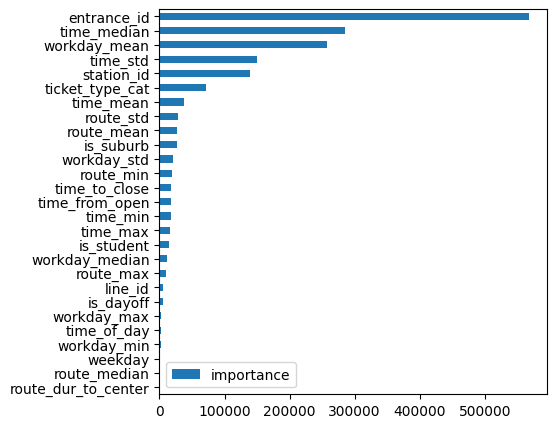

In [84]:
lgbm_feat = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
lgbm_feat.nlargest(30, columns='importance').sort_values(by='importance').plot(kind='barh', figsize=(5, 5))

In [80]:
time_to_under = lgbmodel.predict(df_test_final)
label = model.predict(df_test_final)
pred_df = pd.DataFrame({'id': pd.read_csv('sample_solution.csv').id, 'time_to_under': time_to_under, 'label': label})
pred_df.to_csv('sub_12.csv', index=False)